In [1]:
%config IPCompleter.greedy = True
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn

pd.set_option('mode.chained_assignment', None)
sn.set(rc={'figure.figsize':(9,9)})
sn.set(font_scale=1.4)

# Density estimation

Density estimation is the construction of an estimate, based on observed data, of an unobservable underlying probability density function. The unobservable density function is thought of as the density according to which a large population is distributed; the data are usually thought of as a random sample from that population.

Density estimation walks the line between unsupervised learning, feature
engineering, and data modeling. Some of the most popular and useful
density estimation techniques are mixture models such as Gaussian
Mixtures (`sklearn.mixture.GaussianMixture`
), and neighbor-based approaches such as the kernel density
estimate (`sklearn.neighbors.KernelDensity`
).

Density estimation is a very simple concept, and most people are already
familiar with one common density estimation technique: the histogram.

## Histograms

A histogram is a simple visualization of data where bins are defined,
and the number of data points within each bin is tallied. An example of
a histogram can be seen in the upper-left panel of the following figure:



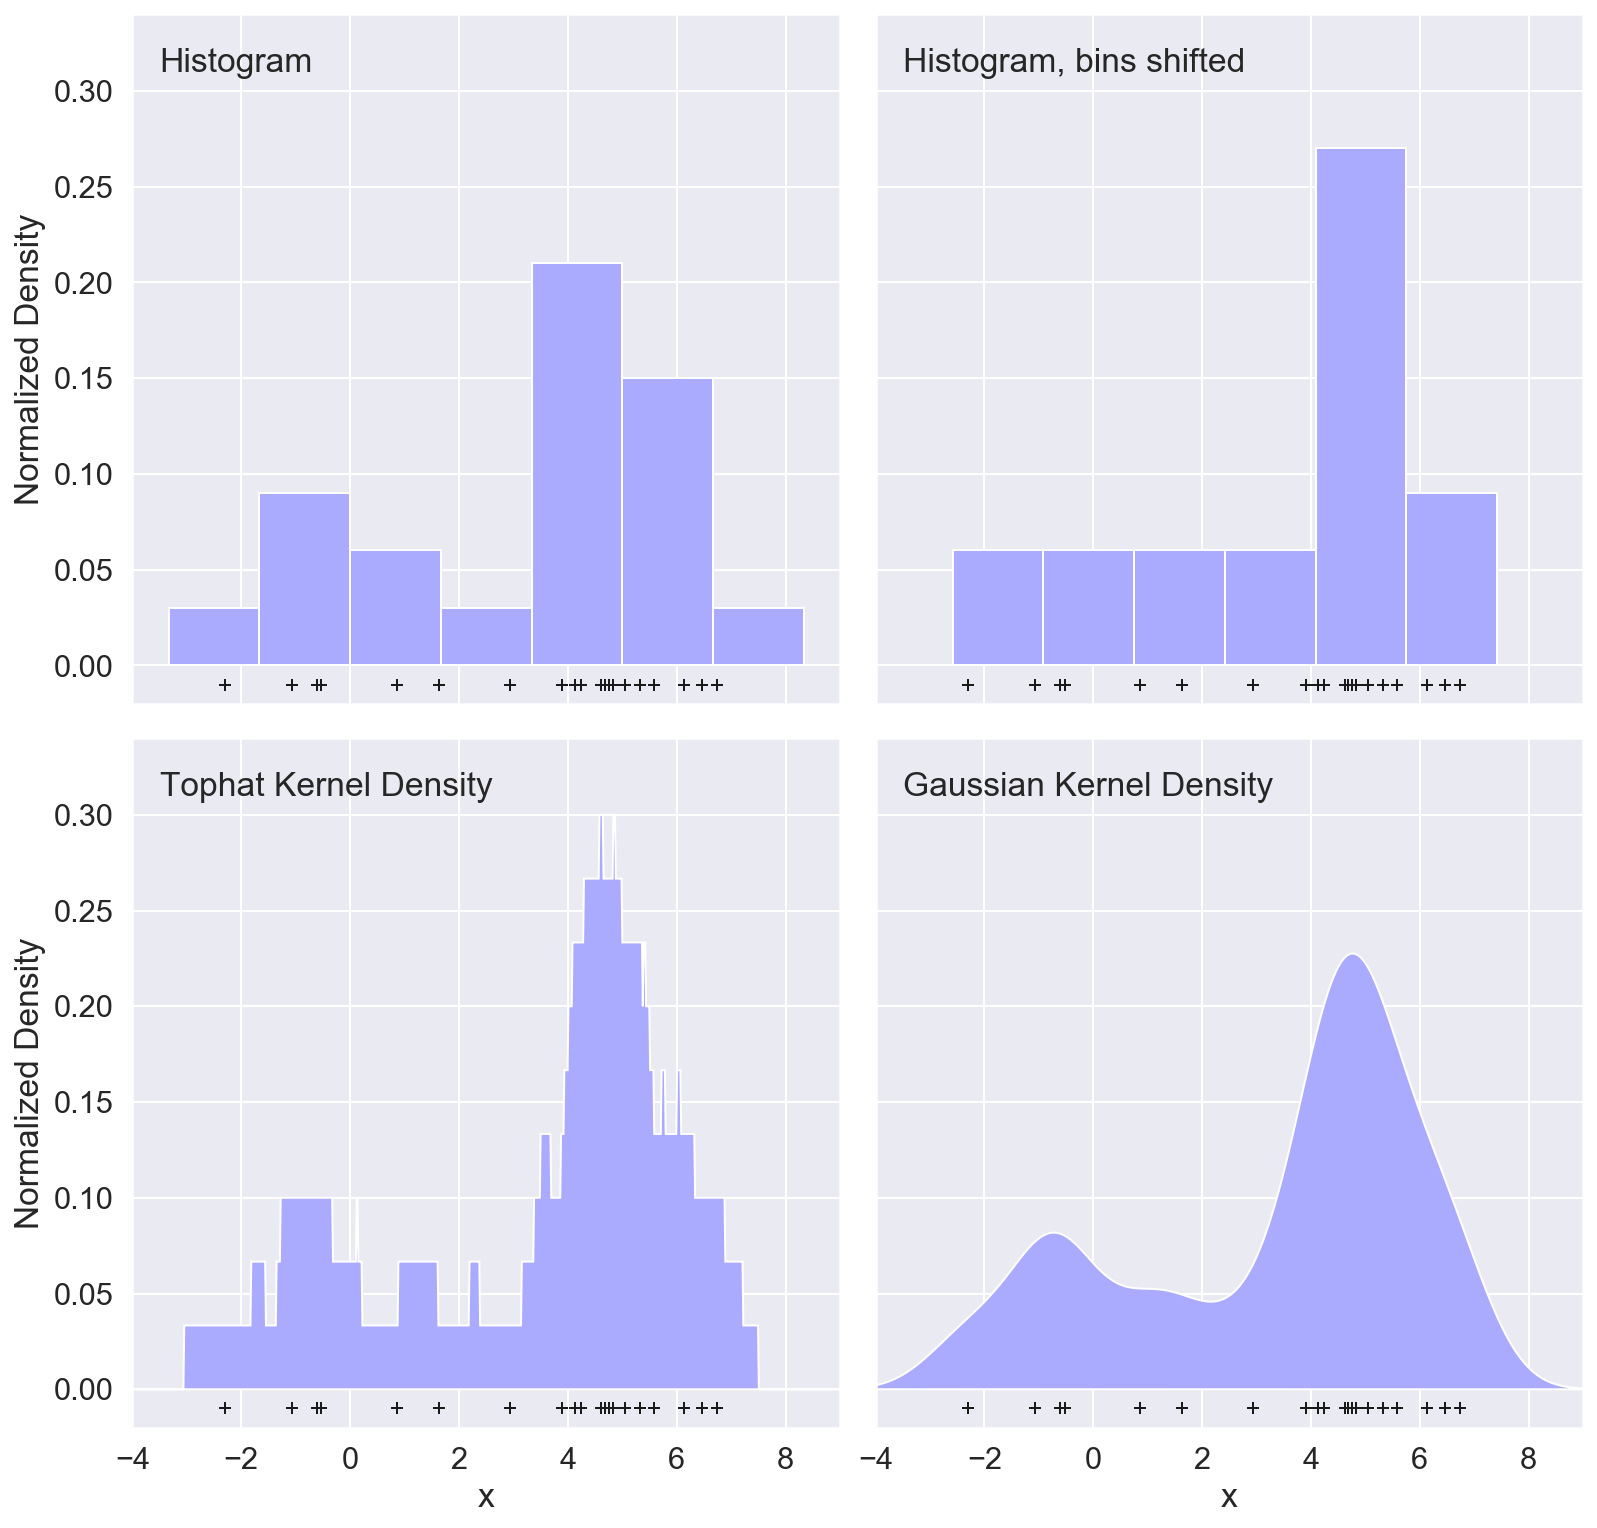

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from distutils.version import LooseVersion
from scipy.stats import norm
from sklearn.neighbors import KernelDensity

# `normed` is being deprecated in favor of `density` in histograms
if LooseVersion(matplotlib.__version__) >= '2.1':
    density_param = {'density': True}
else:
    density_param = {'normed': True}

# ----------------------------------------------------------------------
# Plot the progression of histograms to kernels
np.random.seed(1)
N = 20
X = np.concatenate((np.random.normal(0, 1, int(0.3 * N)),
                    np.random.normal(5, 1, int(0.7 * N))))[:, np.newaxis]
X_plot = np.linspace(-5, 10, 1000)[:, np.newaxis]
bins = np.linspace(-5, 10, 10)

fig, ax = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(13, 13))
fig.subplots_adjust(hspace=0.05, wspace=0.05)

# histogram 1
ax[0, 0].hist(X[:, 0], bins=bins, fc='#AAAAFF', **density_param)
ax[0, 0].text(-3.5, 0.31, "Histogram")

# histogram 2
ax[0, 1].hist(X[:, 0], bins=bins + 0.75, fc='#AAAAFF', **density_param)
ax[0, 1].text(-3.5, 0.31, "Histogram, bins shifted")

# tophat KDE
kde = KernelDensity(kernel='tophat', bandwidth=0.75).fit(X)
log_dens = kde.score_samples(X_plot)
ax[1, 0].fill(X_plot[:, 0], np.exp(log_dens), fc='#AAAAFF')
ax[1, 0].text(-3.5, 0.31, "Tophat Kernel Density")

# Gaussian KDE
kde = KernelDensity(kernel='gaussian', bandwidth=0.75).fit(X)
log_dens = kde.score_samples(X_plot)
ax[1, 1].fill(X_plot[:, 0], np.exp(log_dens), fc='#AAAAFF')
ax[1, 1].text(-3.5, 0.31, "Gaussian Kernel Density")

for axi in ax.ravel():
    axi.plot(X[:, 0], np.full(X.shape[0], -0.01), '+k')
    axi.set_xlim(-4, 9)
    axi.set_ylim(-0.02, 0.34)

for axi in ax[:, 0]:
    axi.set_ylabel('Normalized Density')

for axi in ax[1, :]:
    axi.set_xlabel('x')
    
plt.show()

A major problem with histograms, however, is that the choice of binning
can have a disproportionate effect on the resulting visualization.
Consider the upper-right panel of the above figure. It shows a histogram
over the same data, with the bins shifted right. The results of the two
visualizations look entirely different, and might lead to different
interpretations of the data.

Intuitively, one can also think of a histogram as a stack of blocks, one
block per point. By stacking the blocks in the appropriate grid space,
we recover the histogram. But what if, instead of stacking the blocks on
a regular grid, we center each block on the point it represents, and sum
the total height at each location? This idea leads to the lower-left
visualization. It is perhaps not as clean as a histogram, but the fact
that the data drive the block locations mean that it is a much better
representation of the underlying data.

This visualization is an example of a *kernel density estimation*, in
this case with a top-hat kernel (i.e. a square block at each point). We
can recover a smoother distribution by using a smoother kernel. The
bottom-right plot shows a Gaussian kernel density estimate, in which
each point contributes a Gaussian curve to the total. The result is a
smooth density estimate which is derived from the data, and functions as
a powerful non-parametric model of the distribution of points.

## Kernel Density Estimation

Kernel density estimation is a fundamental data smoothing problem where inferences about the population are made, based on a finite data sample. In some fields such as signal processing and econometrics it is also termed the *Parzen–Rosenblatt window*.

Kernel density estimation in scikit-learn is implemented in the
`sklearn.neighbors.KernelDensity` 
estimator, which uses the Ball Tree or KD Tree for efficient queries. Though the above example uses a 1D data set for simplicity,
kernel density estimation can be performed in any number of dimensions,
though in practice the curse of dimensionality causes its performance to
degrade in high dimensions.

In the following figure, 100 points are drawn from a bimodal
distribution, and the kernel density estimates are shown for three
choices of kernels:


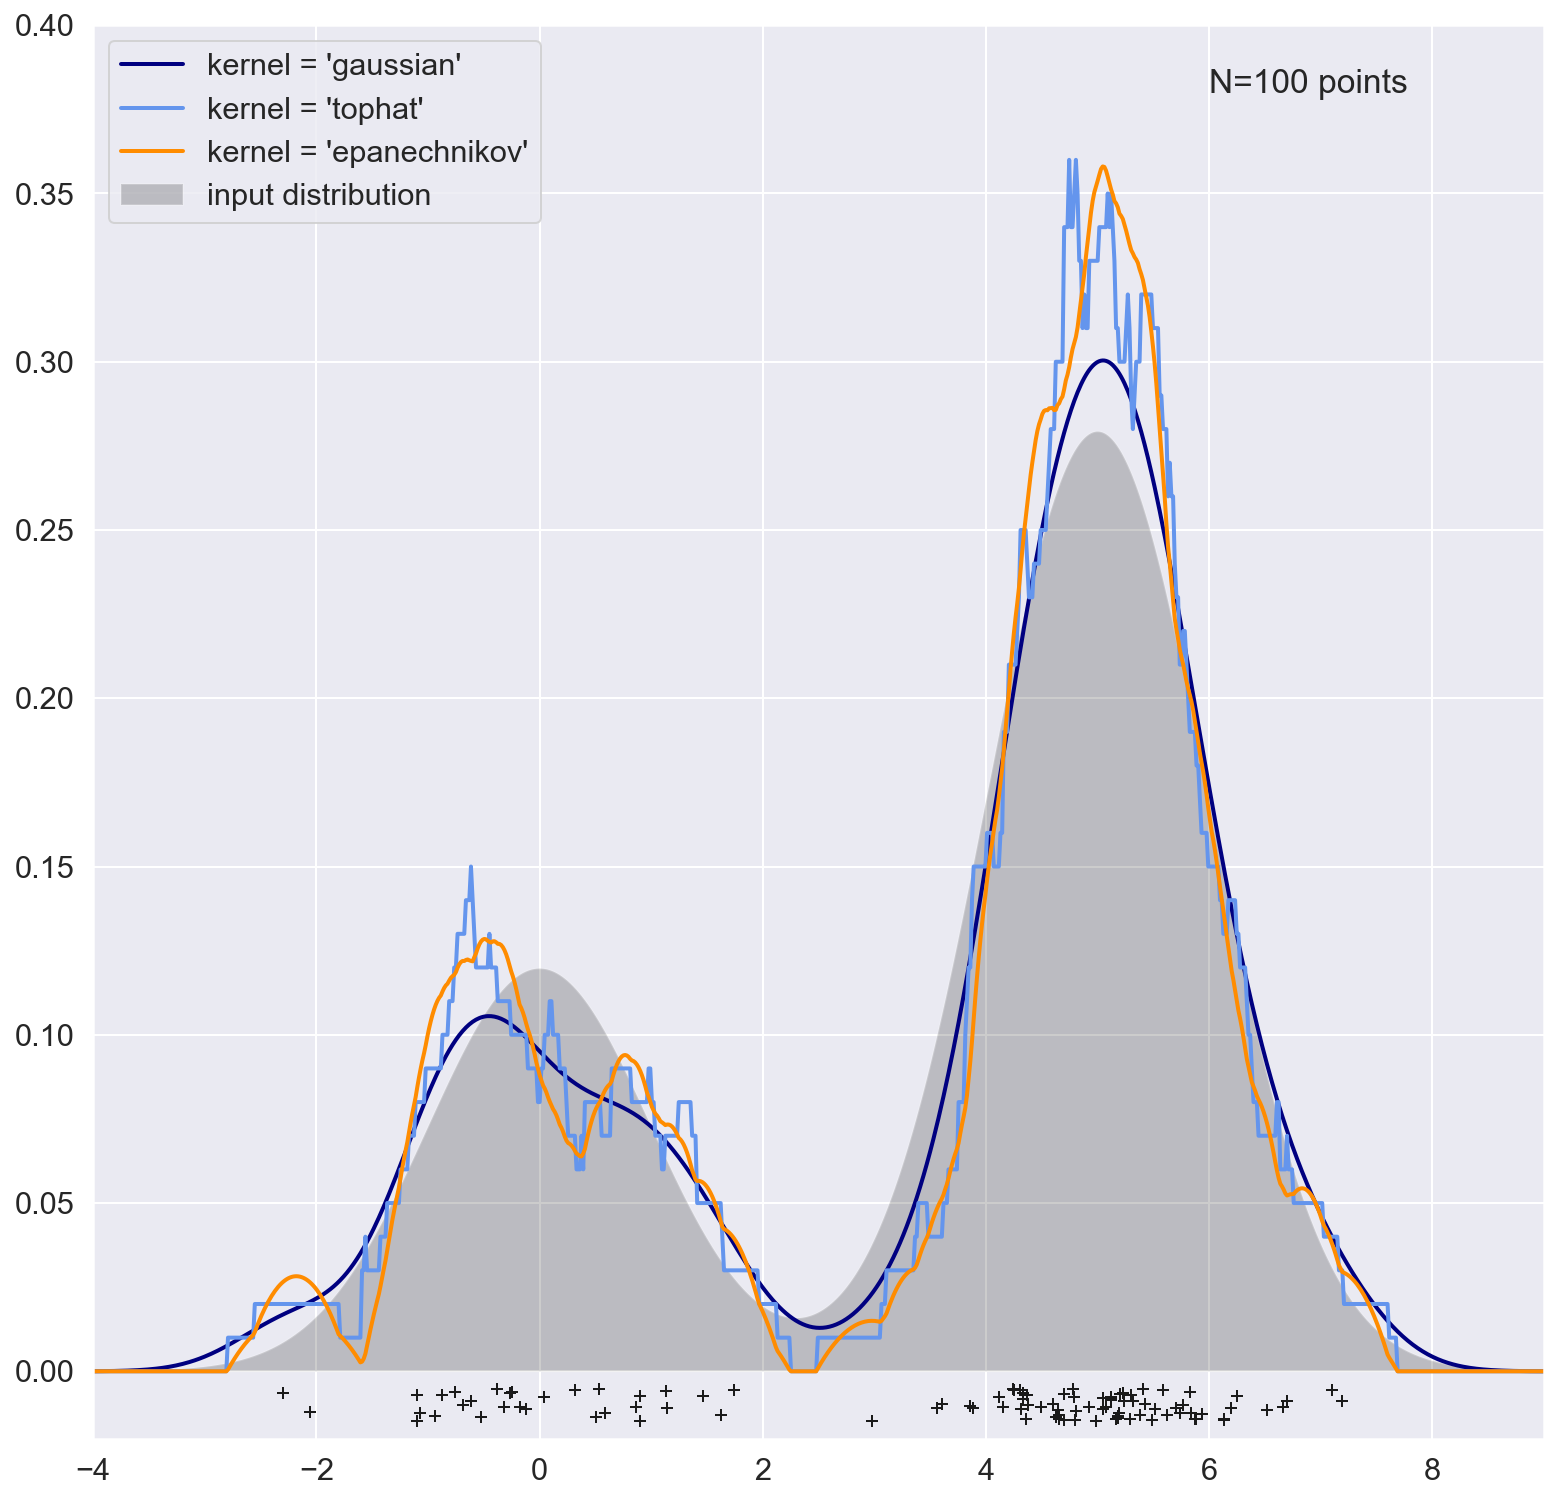

In [3]:
from sklearn.neighbors import KernelDensity
N = 100
np.random.seed(1)
X = np.concatenate((np.random.normal(0, 1, int(0.3 * N)),
                    np.random.normal(5, 1, int(0.7 * N))))[:, np.newaxis]

X_plot = np.linspace(-5, 10, 1000)[:, np.newaxis]

true_dens = (0.3 * norm(0, 1).pdf(X_plot[:, 0])
             + 0.7 * norm(5, 1).pdf(X_plot[:, 0]))

fig, ax = plt.subplots(figsize=(13, 13))
ax.fill(X_plot[:, 0], true_dens, fc='black', alpha=0.2,
        label='input distribution')
colors = ['navy', 'cornflowerblue', 'darkorange']
kernels = ['gaussian', 'tophat', 'epanechnikov']
lw = 2

for color, kernel in zip(colors, kernels):
    kde = KernelDensity(kernel=kernel, bandwidth=0.5).fit(X)
    log_dens = kde.score_samples(X_plot)
    ax.plot(X_plot[:, 0], np.exp(log_dens), color=color, lw=lw,
            linestyle='-', label="kernel = '{0}'".format(kernel))

ax.text(6, 0.38, "N={0} points".format(N))

ax.legend(loc='upper left')
ax.plot(X[:, 0], -0.005 - 0.01 * np.random.random(X.shape[0]), '+k')

ax.set_xlim(-4, 9)
ax.set_ylim(-0.02, 0.4)
plt.show()

It's clear how the kernel shape affects the smoothness of the resulting
distribution. The scikit-learn kernel density estimator can be used as
follows:

In [4]:
from sklearn.neighbors import KernelDensity
import numpy as np
X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(X)
kde.score_samples(X)

array([-0.41075698, -0.41075698, -0.41076071, -0.41075698, -0.41075698,
       -0.41076071])

Here we have used `kernel='gaussian'`, as seen above. Mathematically, a
kernel is a positive function $K(x;h)$ which is controlled by the
bandwidth parameter $h$. Given this kernel form, the density estimate at
a point $y$ within a group of points $x_i; i=1\cdots N$ is given by:

$$\rho_K(y) = \sum_{i=1}^{N} K(y - x_i; h)$$

The bandwidth here acts as a smoothing parameter, controlling the
tradeoff between bias and variance in the result. A large bandwidth
leads to a very smooth (i.e. high-bias) density distribution. A small
bandwidth leads to an unsmooth (i.e. high-variance) density
distribution.

`sklearn.neighbors.KernelDensity` 
implements several common kernel forms, which are shown in the following
figure:

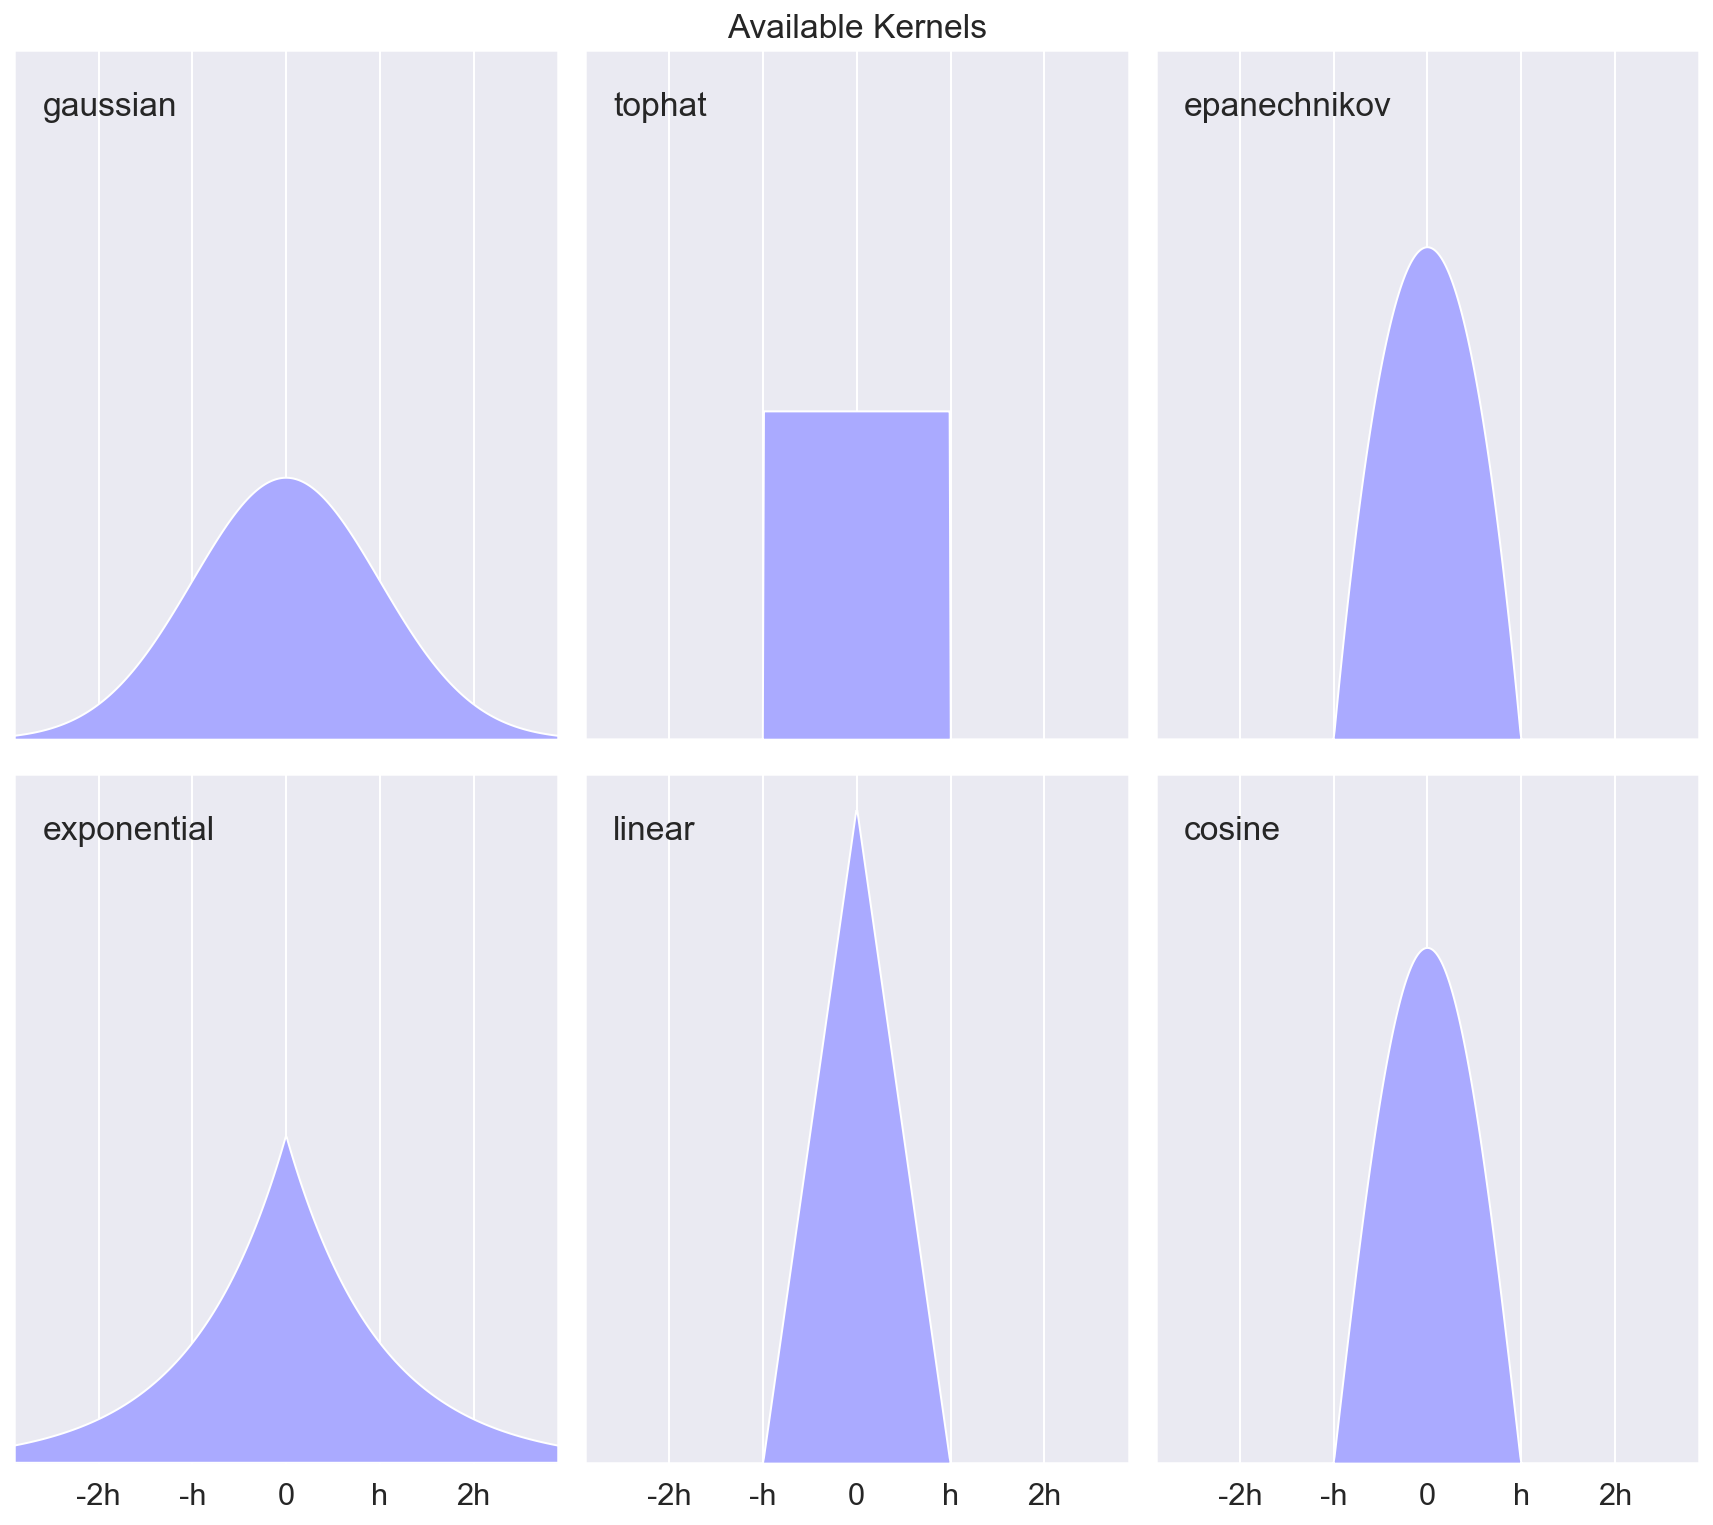

In [5]:
X_plot = np.linspace(-6, 6, 1000)[:, None]
X_src = np.zeros((1, 1))

fig, ax = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(13, 13))
fig.subplots_adjust(left=0.05, right=0.95, hspace=0.05, wspace=0.05)


def format_func(x, loc):
    if x == 0:
        return '0'
    elif x == 1:
        return 'h'
    elif x == -1:
        return '-h'
    else:
        return '%ih' % x

for i, kernel in enumerate(['gaussian', 'tophat', 'epanechnikov',
                            'exponential', 'linear', 'cosine']):
    axi = ax.ravel()[i]
    log_dens = KernelDensity(kernel=kernel).fit(X_src).score_samples(X_plot)
    axi.fill(X_plot[:, 0], np.exp(log_dens), '-k', fc='#AAAAFF')
    axi.text(-2.6, 0.95, kernel)

    axi.xaxis.set_major_formatter(plt.FuncFormatter(format_func))
    axi.xaxis.set_major_locator(plt.MultipleLocator(1))
    axi.yaxis.set_major_locator(plt.NullLocator())

    axi.set_ylim(0, 1.05)
    axi.set_xlim(-2.9, 2.9)

ax[0, 1].set_title('Available Kernels')
plt.show()

The form of these kernels is as follows:

-   Gaussian kernel (`kernel = 'gaussian'`)

    $K(x; h) \propto \exp(- \frac{x^2}{2h^2} )$

-   Tophat kernel (`kernel = 'tophat'`)

    $K(x; h) \propto 1$ if $x < h$

-   Epanechnikov kernel (`kernel = 'epanechnikov'`)

    $K(x; h) \propto 1 - \frac{x^2}{h^2}$

-   Exponential kernel (`kernel = 'exponential'`)

    $K(x; h) \propto \exp(-x/h)$

-   Linear kernel (`kernel = 'linear'`)

    $K(x; h) \propto 1 - x/h$ if $x < h$

-   Cosine kernel (`kernel = 'cosine'`)

    $K(x; h) \propto \cos(\frac{\pi x}{2h})$ if $x < h$

The kernel density estimator can be used with any of the valid distance
metrics (see `sklearn.neighbors.DistanceMetric`
 for a list of available metrics), though the results are
properly normalized only for the Euclidean metric. One particularly
useful metric is the [Haversine
distance](https://en.wikipedia.org/wiki/Haversine_formula) which
measures the angular distance between points on a sphere. Here is an
example of using a kernel density estimate for a visualization of
geospatial data, in this case the distribution of observations of two
different species on the South American continent:

 - computing KDE in spherical coordinates
 - plot coastlines from coverage
 - computing KDE in spherical coordinates
 - plot coastlines from coverage


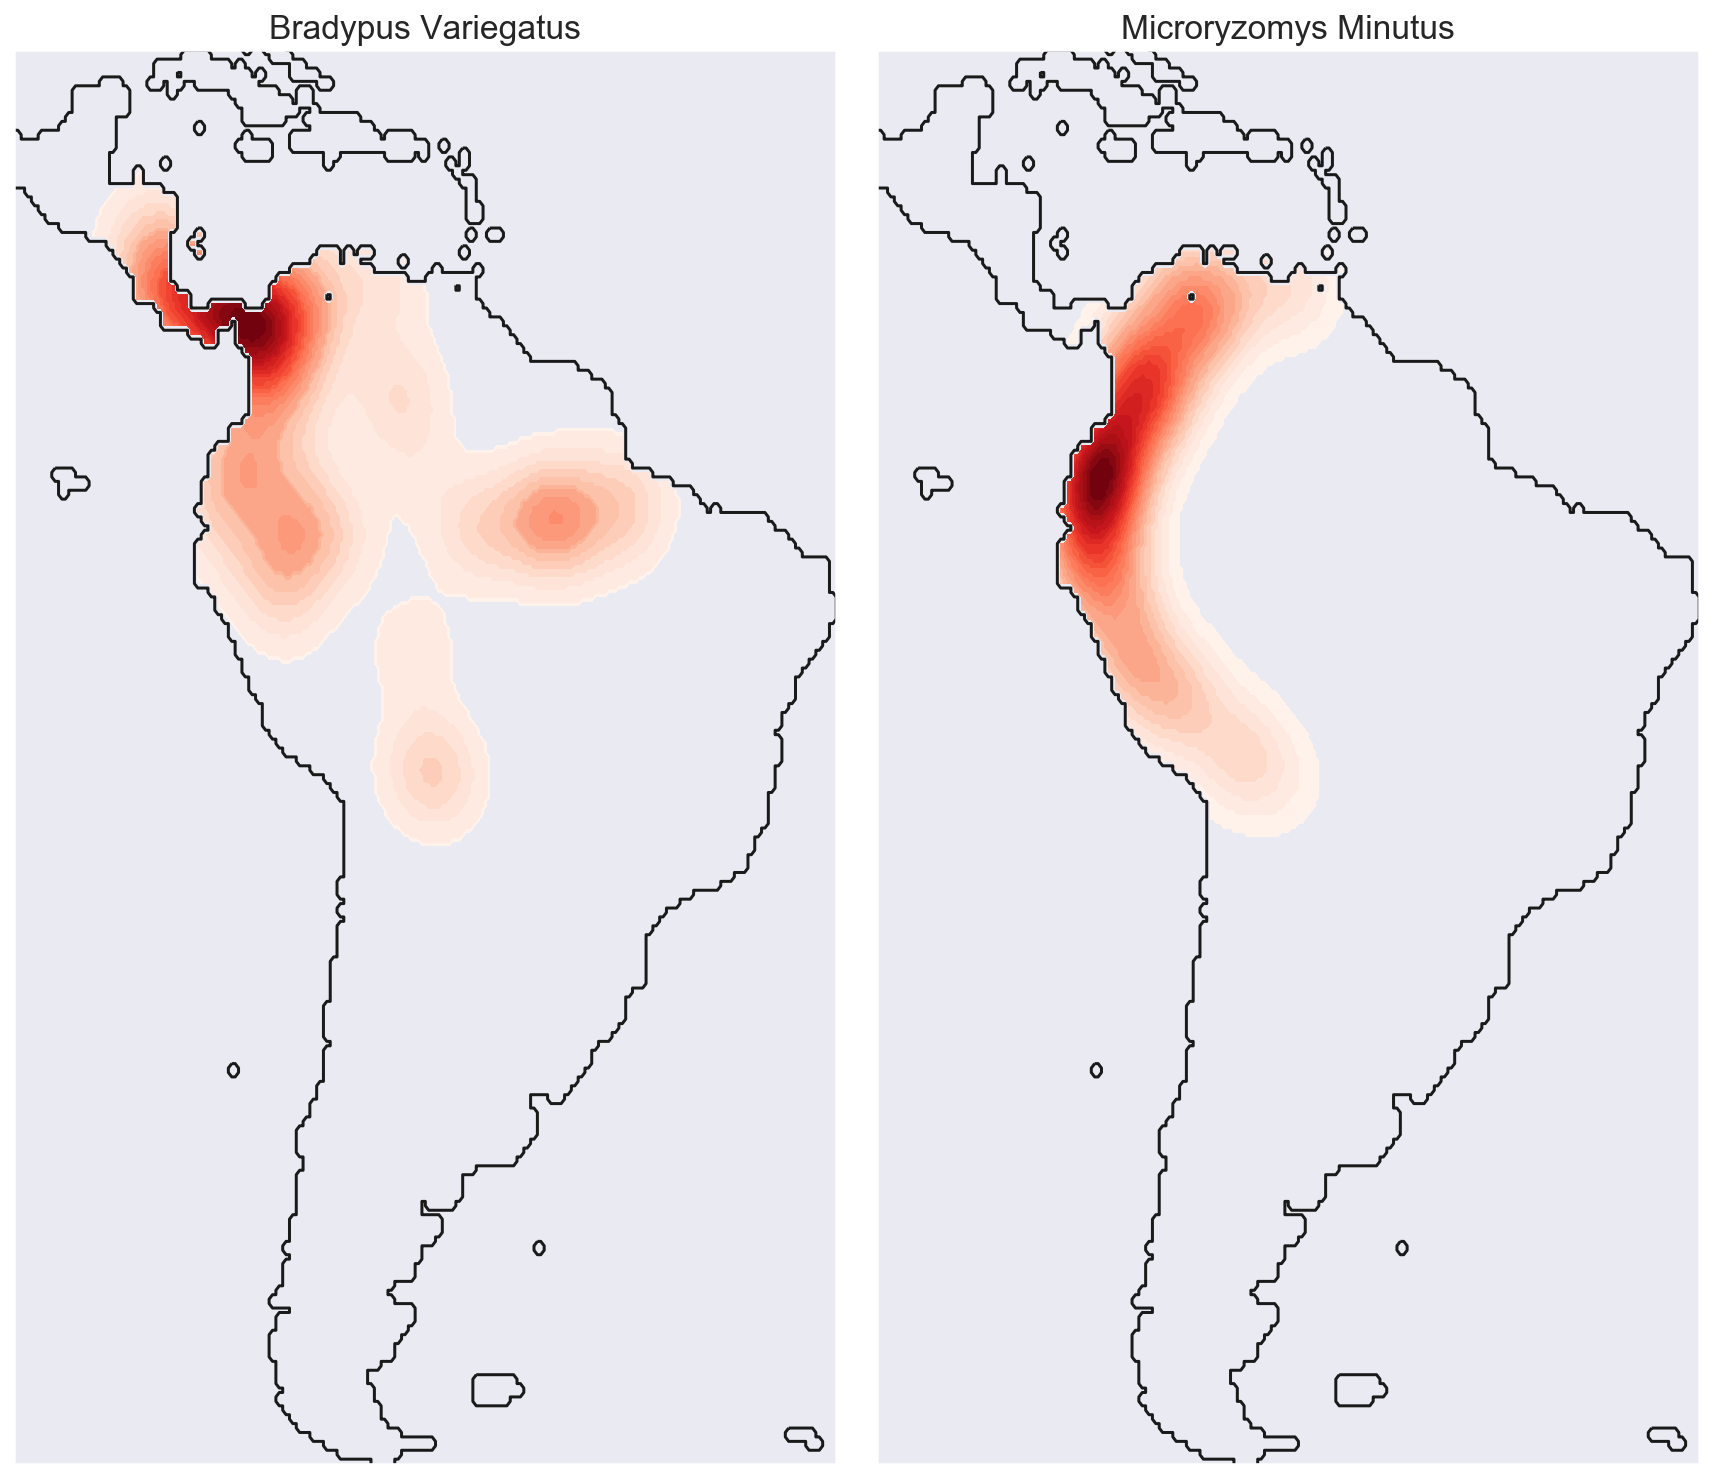

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_species_distributions
from sklearn.neighbors import KernelDensity

# if basemap is available, we'll use it.
# otherwise, we'll improvise later...
try:
    from mpl_toolkits.basemap import Basemap
    basemap = True
except ImportError:
    basemap = False


def construct_grids(batch):
    """Construct the map grid from the batch object

    Parameters
    ----------
    batch : Batch object
        The object returned by :func:`fetch_species_distributions`

    Returns
    -------
    (xgrid, ygrid) : 1-D arrays
        The grid corresponding to the values in batch.coverages
    """
    # x,y coordinates for corner cells
    xmin = batch.x_left_lower_corner + batch.grid_size
    xmax = xmin + (batch.Nx * batch.grid_size)
    ymin = batch.y_left_lower_corner + batch.grid_size
    ymax = ymin + (batch.Ny * batch.grid_size)

    # x coordinates of the grid cells
    xgrid = np.arange(xmin, xmax, batch.grid_size)
    # y coordinates of the grid cells
    ygrid = np.arange(ymin, ymax, batch.grid_size)

    return (xgrid, ygrid)


# Get matrices/arrays of species IDs and locations
data = fetch_species_distributions()
species_names = ['Bradypus Variegatus', 'Microryzomys Minutus']

Xtrain = np.vstack([data['train']['dd lat'],
                    data['train']['dd long']]).T
ytrain = np.array([d.decode('ascii').startswith('micro')
                  for d in data['train']['species']], dtype='int')
Xtrain *= np.pi / 180.  # Convert lat/long to radians

# Set up the data grid for the contour plot
xgrid, ygrid = construct_grids(data)
X, Y = np.meshgrid(xgrid[::5], ygrid[::5][::-1])
land_reference = data.coverages[6][::5, ::5]
land_mask = (land_reference > -9999).ravel()

xy = np.vstack([Y.ravel(), X.ravel()]).T
xy = xy[land_mask]
xy *= np.pi / 180.

# Plot map of South America with distributions of each species
fig = plt.figure(figsize=(13, 13))
fig.subplots_adjust(left=0.05, right=0.95, wspace=0.05)

for i in range(2):
    plt.subplot(1, 2, i + 1)

    # construct a kernel density estimate of the distribution
    print(" - computing KDE in spherical coordinates")
    kde = KernelDensity(bandwidth=0.04, metric='haversine',
                        kernel='gaussian', algorithm='ball_tree')
    kde.fit(Xtrain[ytrain == i])

    # evaluate only on the land: -9999 indicates ocean
    Z = np.full(land_mask.shape[0], -9999, dtype='int')
    Z[land_mask] = np.exp(kde.score_samples(xy))
    Z = Z.reshape(X.shape)

    # plot contours of the density
    levels = np.linspace(0, Z.max(), 25)
    plt.contourf(X, Y, Z, levels=levels, cmap=plt.cm.Reds)

    if basemap:
        print(" - plot coastlines using basemap")
        m = Basemap(projection='cyl', llcrnrlat=Y.min(),
                    urcrnrlat=Y.max(), llcrnrlon=X.min(),
                    urcrnrlon=X.max(), resolution='c')
        m.drawcoastlines()
        m.drawcountries()
    else:
        print(" - plot coastlines from coverage")
        plt.contour(X, Y, land_reference,
                    levels=[-9998], colors="k",
                    linestyles="solid")
        plt.xticks([])
        plt.yticks([])

    plt.title(species_names[i])

plt.show()

One other useful application of kernel density estimation is to learn a non-parametric generative model of a dataset in order to efficiently draw new samples from this generative model. Here is an example of using this process to create a new set of hand-written digits, using a Gaussian kernel learned on a PCA projection of the data:

best bandwidth: 3.79269019073225


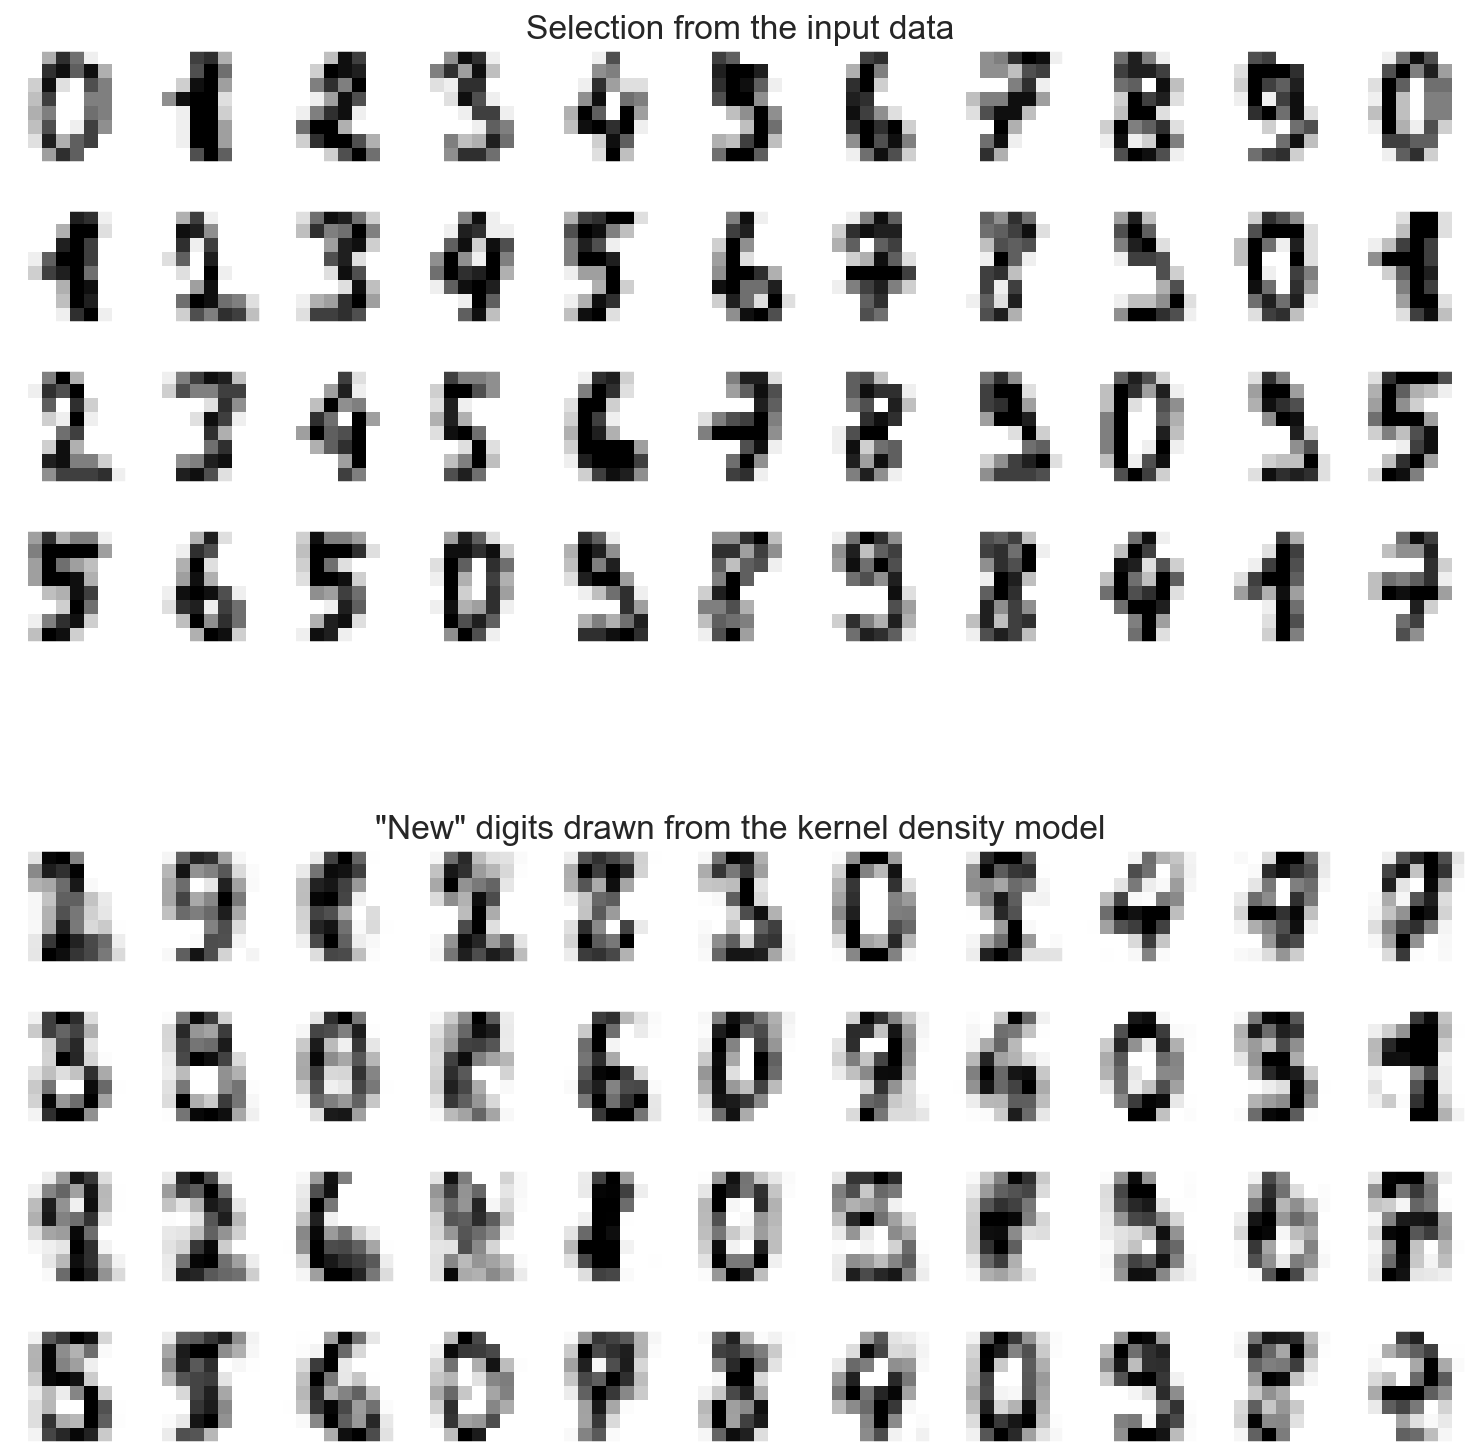

In [7]:
from sklearn.datasets import load_digits
from sklearn.neighbors import KernelDensity
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

# load the data
digits = load_digits()

# project the 64-dimensional data to a lower dimension
pca = PCA(n_components=15, whiten=False)
data = pca.fit_transform(digits.data)

# use grid search cross-validation to optimize the bandwidth
params = {'bandwidth': np.logspace(-1, 1, 20)}
grid = GridSearchCV(KernelDensity(), params)
grid.fit(data)

print("best bandwidth: {0}".format(grid.best_estimator_.bandwidth))

# use the best estimator to compute the kernel density estimate
kde = grid.best_estimator_

# sample 44 new points from the data
new_data = kde.sample(44, random_state=0)
new_data = pca.inverse_transform(new_data)

# turn data into a 4x11 grid
new_data = new_data.reshape((4, 11, -1))
real_data = digits.data[:44].reshape((4, 11, -1))

# plot real digits and resampled digits
fig, ax = plt.subplots(9, 11, subplot_kw=dict(xticks=[], yticks=[]), figsize=(13, 13))
for j in range(11):
    ax[4, j].set_visible(False)
    for i in range(4):
        im = ax[i, j].imshow(real_data[i, j].reshape((8, 8)),
                             cmap=plt.cm.binary, interpolation='nearest')
        im.set_clim(0, 16)
        im = ax[i + 5, j].imshow(new_data[i, j].reshape((8, 8)),
                                 cmap=plt.cm.binary, interpolation='nearest')
        im.set_clim(0, 16)

ax[0, 5].set_title('Selection from the input data')
ax[5, 5].set_title('"New" digits drawn from the kernel density model')

plt.show()

The “new” data consists of linear combinations of the input data, with weights probabilistically drawn given the KDE model.
[[1](https://scikit-learn.org/stable/modules/density.html)]